# Redlining in Loveland, Colorado

Loveland, Colorado was officially establised in 1881. Named after the president of the Colorado Central Railroad, William A.H.Loveland, the city was established alongside newly constructed railroad line that connected Denver in the South to Fort Collins in the North. 

With the railroad, Loveland soon established itself as a shipping point for farmers, ranchers, and lunber suppliers.  and it's population more than trippled between 1882 and 1885. In 1901, the Great Western Sugar Company build a factor in Loveland which remains a primary source of employment until it's closure over 80 years later in 1985. 

Today, Loveland is the center of one of the fastest growing regions in the Nation, Northern Colorado - known as NoCo. The City's population as of 202 was 76,378.

## A Troubled Past

Of the 20 most populous cities in Colorado, Loveland is the whitest, with 84% identifying as 'white only' (kunc refernce)

This artificial 'whiteness' is not by accident. {reference } Prior to 1960, Loveland was one of the many towns in the United States that had unspoken 'Sundown Laws' which implied that people of color, Black or Hispanic, were not welcome. People arriving in Loveland were greeted by signs welcoming them to the "Nationally Famous Sweethart Town" with an additional sign underneath that read "We observe the Jim Crow Laws here." Many downtown businesses had signs stating 'White-Trade Only". Histanic residents who grew up in 50s and 60s recalled that people 'like them' just didn't live in certain parts of town (mostly West of the railroad tracks).

Loveland was known as a 'Sundowner Town' where "Black people were not allowed to be within the city limits after hours. And brown people were basically treated as second-class citizens," according to Bob Adame, a 73-year-old Loveland resident. In direct violation of Colorado state law that guarenteed residents access to public places regardless of race, many neighborhoods with HOAs mades sure that only whites could purchase homes. 

While progress has been made, the Citys black population is still only 1.5%, and it's hispanic population approximatley 3%. At a city councl meeting in 2021, when the city was considering measures to give non-white and LGBTQ residents more of a voice, one older white resident stated "I am not a fan of multiracilaims to be truthful. You can call me a racist if you want to."

References:

https://loveland.org/explore-loveland/loveland/facts-history/history-of-loveland/
https://www.reporterherald.com/2016/07/02/loveland-wasnt-immune-to-nations-divided-past/?clearUserState=true
https://www.kunc.org/2021-09-13/loveland-colorado-splinters-over-racist-sundown-town-past-and-increasingly-diverse-future


## Import Necessary Packages

In [6]:
import os # Interoperable file paths
import pathlib # Find the home folder
import geopandas as gpd # Work with vector data
import hvplot
import hvplot.pandas # Interactive plots of vector data


In [7]:
data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'fortcollinsrl'
)
os.makedirs(data_dir, exist_ok=True)

## STEP 2: Site map

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Define your study area</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Copy the <strong>geopackage</strong> URL for the <a
href="https://dsl.richmond.edu/panorama/redlining/data">University of
Richmond</a></li>
<li>Load the <em>vector</em> data into Python, making sure to cache the
download so you don’t have to run it multiple times.</li>
<li>Create a quick plot to check the data</li>
</ol></div></div>

<Axes: >

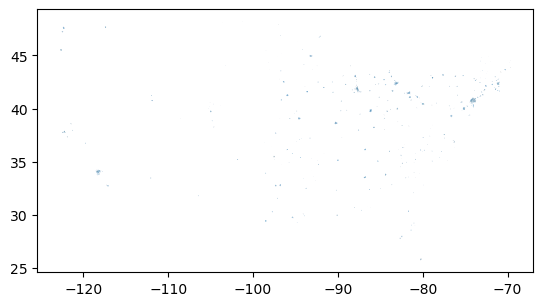

In [8]:
# Define info for redlining download
fortcollinsrl_url = (
    "https://dsl.richmond.edu"
    "/panorama/redlining/static/"
    "mappinginequality.gpkg"
)
# Set up a path to save the data on your machine
fortcollinsrl_dir = os.path.join(data_dir, 'fortcollinsrl')

# Make the redlining directory
os.makedirs(fortcollinsrl_dir, exist_ok=True)

# Join regions shapefile path
fortcollinsrl_path = os.path.join(fortcollinsrl_dir, 'fortcollinsrl.gpkg')

# Only download once
if not os.path.exists(fortcollinsrl_path):
    # Read the GeoPackage file from the URL
    fortcollinsrl_gdf = gpd.read_file(fortcollinsrl_url)
    # Save the data as a GeoPackage to the local path
    fortcollinsrl_gdf.to_file(fortcollinsrl_path, driver='GPKG')

# Load from file
fortcollinsrl_gdf = gpd.read_file(fortcollinsrl_path)

#Check the data
fortcollinsrl_gdf.plot()

In [4]:
fortcollinsrl_gdf.head(5)

,area_id,city,state,city_survey,category,grade,label,residential,commercial,industrial,fill,geometry
0,244,Birmingham,AL,True,Best,A,A1,True,False,False,#76a865,"MULTIPOLYGON (((-86.75678 33.49754, -86.75653 ..."
1,193,Birmingham,AL,True,Best,A,A2,True,False,False,#76a865,"MULTIPOLYGON (((-86.75867 33.50933, -86.76134 ..."
2,206,Birmingham,AL,True,Best,A,A3,True,False,False,#76a865,"MULTIPOLYGON (((-86.75678 33.49754, -86.75692 ..."
3,203,Birmingham,AL,True,Still Desirable,B,B1,True,False,False,#7cb5bd,"MULTIPOLYGON (((-86.80111 33.48071, -86.80505 ..."
4,189,Birmingham,AL,True,Still Desirable,B,B10,True,False,False,#7cb5bd,"MULTIPOLYGON (((-86.74923 33.53333, -86.74971 ..."


In [9]:
# # Create an interactive site map

fortcollins_redlining_gdf = fortcollinsrl_gdf[fortcollinsrl_gdf.city=='Fort Collins'] 

fortcollins_redlining_gdf.dissolve().hvplot(
    geo=True, tiles='EsriImagery',
    title='City of Fort Collins',
    fill_color=None, line_color='red', line_width=3,
    frame_width=600
)

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [6]:

# Print the filtered GeoDataFrame to check if it's empty
print(fortcollins_redlining_gdf)


      area_id          city state  city_survey       category grade  \
1159    10382  Fort Collins    CO        False   Fourth Grade         
1160    10383  Fort Collins    CO        False    First Grade         
1161    10384  Fort Collins    CO        False   Second Grade         
1162    10385  Fort Collins    CO        False    Third Grade         
1163    10386  Fort Collins    CO        False  Fire District         

              label  residential  commercial  industrial     fill  \
1159   Fourth Grade         True       False       False  #561f18   
1160    First Grade         True       False       False  #2d3352   
1161   Second Grade         True       False       False  #364f3a   
1162    Third Grade         True       False       False  #afa53d   
1163  Fire District        False       False       False  #cbb5a2   

                                               geometry  
1159  MULTIPOLYGON (((-105.07481 40.59251, -105.0765...  
1160  MULTIPOLYGON (((-105.0756 40.56528, 

In [10]:
import os # Reproducible file paths
import re # Extract metadata from file names
import zipfile # Work with zip files
from io import BytesIO # Stream binary (zip) files
from glob import glob # Find files by pattern
import numpy as np # Unpack bit-wise Fmask
import matplotlib.pyplot as plt # Make subplots
import requests # Request data over HTTP
# import rioxarray as rxr # Work with geospatial raster data

In [2]:
import rasterio

# STEP 3: Download and prepare green reflectance data

## Working with **raster** data

**Raster** data is arranged on a grid – for example a digital
photograph.

In [11]:
# Prepare URL and file path for download (HLS stands for Harmonized Landsat Sentinel-2 (HLS) Project) This is a combination of data taken by NASA Landsat missions and the European Space Agency(ESA) sentinel-2 mission.
hls_URL = ("https://github.com/cu-esiil-edu/esiil-learning-portal"
    "/releases/download/data-release/"
    "redlining-foundations-data.zip"
)

hls_dir = os.path.join (
    data_dir,
    'hls'
)

if not os.path.exists(hls_dir):
    # Download sample raster data
    response = requests.get(hls_URL)

    # Save the raster data (uncompressed)
    with zipfile.ZipFile(BytesIO(response.content)) as hls_zip:
        hls_zip.extractall(hls_dir)

## Working with Multispectral Data

In [12]:
# Find the path to the green layer
green_path = glob(os.path.join(hls_dir, '*B03.tif'))[0]

# Open the green data in Python
green_da = rxr.open_rasterio(green_path, mask_and_scale=True).squeeze()
display(green_da)
green_da.plot(cmap='Greens', vmin=0, robust=True)

NameError: name 'rxr' is not defined